## Dependencies

In [1]:
import json
import math

import joblib
import keras
import shap
import warnings
import pandas as pd
import numpy as np
import seaborn as sns

from IPython.display import display
from keras import models

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from util.dataframe_util import str_df, data_features, encode_retirement_features, transform, build_anomaly_model, build_embedding_model

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedShuffleSplit
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, classification_report, roc_auc_score, \
    precision_recall_curve

warnings.filterwarnings('ignore')
sns.set_theme(
    style="darkgrid",
    palette="colorblind",
    font_scale=1.2
)

SPLIT_RATIO = 0.2
ANOMALY_RATE = 0.325
PROB_THRESHOLD = 0.45

/Users/mikkezavala/Library/Mobile Documents/com~apple~CloudDocs/Documents/School/Master in Data Science/[DS-6390] Visualization of Information/FinalProject/modeling/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load and Inspect Data

Data was designed to extract from the image, but had a truth column, we are only keeping that for the simplicity of the project. We are mixing validation here just for the sake of have more data as possible to see patterns we will split later

In [2]:
data_train = pd.read_parquet("data/train-data.parquet")
# data_test = pd.read_parquet("data/test-data.parquet")
# data_validation = pd.read_parquet("data/validation-data.parquet")

parsed_train = data_train['ground_truth'].apply(json.loads)
# parsed_test = data_test['ground_truth'].apply(json.loads)
# parsed_validation = data_validation['ground_truth'].apply(json.loads)

# combined = pd.concat([parsed_test, parsed_validation], ignore_index=True)
parsed = pd.json_normalize(parsed_train.map(lambda x: x['gt_parse']))
print(f"Total rows {parsed.size}")

parsed.head()

Total rows 81000


,box_b_employer_identification_number,box_c_employer_name,box_c_employer_street_address,box_c_employer_city_state_zip,box_a_employee_ssn,box_e_employee_name,box_e_employee_street_address,box_e_employee_city_state_zip,box_d_control_number,box_1_wages,...,box_18_1_local_wages,box_19_1_local_income_tax,box_20_1_locality,box_15_2_state,box_15_2_employee_state_id,box_16_2_state_wages,box_17_2_state_income_tax,box_18_2_local_wages,box_19_2_local_income_tax,box_20_2_locality
0,47-5592725,"Bennett, Allen and Yang Inc",40301 Cameron Village Suite 661,Aguirrebury NH 36219-7671,412-88-2525,Michele Hebert,9888 Zimmerman Roads Apt. 425,Moorestad MO 77456-6485,4390616,141194.15,...,149192.10,15907.50,Linda Locks,UT,683-42-008,76900.70,6670.94,99940.24,15871.27,Rowland Loop
1,87-6351907,White-Rivera Group,9072 Singh Crossroad,Evanschester PA 40143-7536,292-56-8497,Joseph Spencer,8501 Williams Brooks,West Crystal FL 96717-2877,7026178,177856.29,...,128884.24,26310.02,Martinez Prairie,CT,703-82-868,90577.93,4375.04,215991.15,19707.87,Peters Avenue
2,06-6105986,Bryant Ltd Group,82582 William Cape Suite 370,Scottside ND 93090-3134,192-67-3262,Ann Hill,39572 Jack Trail Apt. 308,New Sarahside MN 56848-7193,4117628,238111.55,...,287711.19,46607.90,Miller Oval,NM,479-35-220,120041.89,9397.15,301013.17,24688.05,Gomez Coves
3,84-4920002,Durham-Kaiser and Sons,423 Mallory Tunnel Apt. 129,Port James MD 27987-1171,829-30-6920,Daniel Jenkins,3000 Jeffrey Groves,New Destiny NC 81882-1817,3272509,172580.36,...,201665.80,20341.98,Alan Port,TX,567-81-851,94277.34,9201.90,201819.69,26836.99,Combs Knoll
4,99-4893576,Shaw PLC Ltd,761 Mckee Mills Apt. 025,South Jennifer CO 16817-8765,456-56-2155,Katie Green,60178 Karen Alley Apt. 150,Arthurside RI 68154-2932,3107483,148670.26,...,119538.03,25871.04,Ramirez Road,TX,980-18-083,70825.54,5460.23,147457.42,20858.73,Flores Stream


### Clean Data

In [3]:
# Emulate R "str"
df_details = str_df(parsed).to_dict('records')

# box_9_advance_eic_payment - All column is None
target_drop = [
    'box_b_employer_identification_number',
    'box_d_control_number',
    'box_9_advance_eic_payment',
    'box_15_2_employee_state_id',
    'box_15_1_employee_state_id'
]
continuous, categorical, drop_list = (
    [f['column'] for f in df_details if pd.api.types.is_numeric_dtype(f['dtype']) and len(f['sample_values']) > 3],
    [f['column'] for f in df_details if not pd.api.types.is_numeric_dtype(f['dtype']) or len(f['sample_values']) <= 3],
    [f['column'] for f in df_details if f["column"].startswith('box_c') or f["column"].startswith('box_a') or f["column"].startswith('box_e') or f["column"].startswith('box_20') or f['column'] in target_drop],
)

# Now there are boxes looks like binary but encoded with x, None. x=True, None=False
columns_encode = ['box_13_statutary_employee', 'box_13_retirement_plan', 'box_13_third_part_sick_pay']
parsed[columns_encode] = parsed[columns_encode].replace({'x': True, "None": False, np.nan: False}).astype(bool)
parsed[parsed.select_dtypes(exclude=['bool', 'float64', 'int64']).columns] = parsed.select_dtypes(exclude=['bool', 'float64', 'int64']).astype('category')
parsed[parsed.select_dtypes(include=['bool']).columns] = parsed.select_dtypes(include=['bool']).astype('int64')
# Drop and inspect
original_data = parsed.drop(drop_list, axis=1)

str_df(original_data)

original_data.head()

,box_1_wages,box_2_federal_tax_withheld,box_3_social_security_wages,box_4_social_security_tax_withheld,box_5_medicare_wages,box_6_medicare_wages_tax_withheld,box_7_social_security_tips,box_8_allocated_tips,box_10_dependent_care_benefits,box_11_nonqualified_plans,...,box_15_1_state,box_16_1_state_wages,box_17_1_state_income_tax,box_18_1_local_wages,box_19_1_local_income_tax,box_15_2_state,box_16_2_state_wages,box_17_2_state_income_tax,box_18_2_local_wages,box_19_2_local_income_tax
0,141194.15,37276.89,169708.96,12982.74,181642.61,5267.64,169708.96,181642.61,220,158,...,NC,64971.88,7258.57,149192.10,15907.50,UT,76900.70,6670.94,99940.24,15871.27
1,177856.29,33668.13,197623.14,15118.17,212875.46,6173.39,197623.14,212875.46,297,186,...,SC,95662.66,5075.61,128884.24,26310.02,CT,90577.93,4375.04,215991.15,19707.87
2,238111.55,71007.86,309486.28,23675.70,205695.97,5965.18,309486.28,205695.97,198,157,...,AL,121453.85,6858.46,287711.19,46607.90,NM,120041.89,9397.15,301013.17,24688.05
3,172580.36,39849.36,181555.13,13888.97,183423.78,5319.29,181555.13,183423.78,142,121,...,AR,93302.60,8216.98,201665.80,20341.98,TX,94277.34,9201.90,201819.69,26836.99
4,148670.26,35079.14,113454.73,8679.29,115304.28,3343.82,113454.73,115304.28,289,151,...,NE,67691.66,7191.07,119538.03,25871.04,TX,70825.54,5460.23,147457.42,20858.73


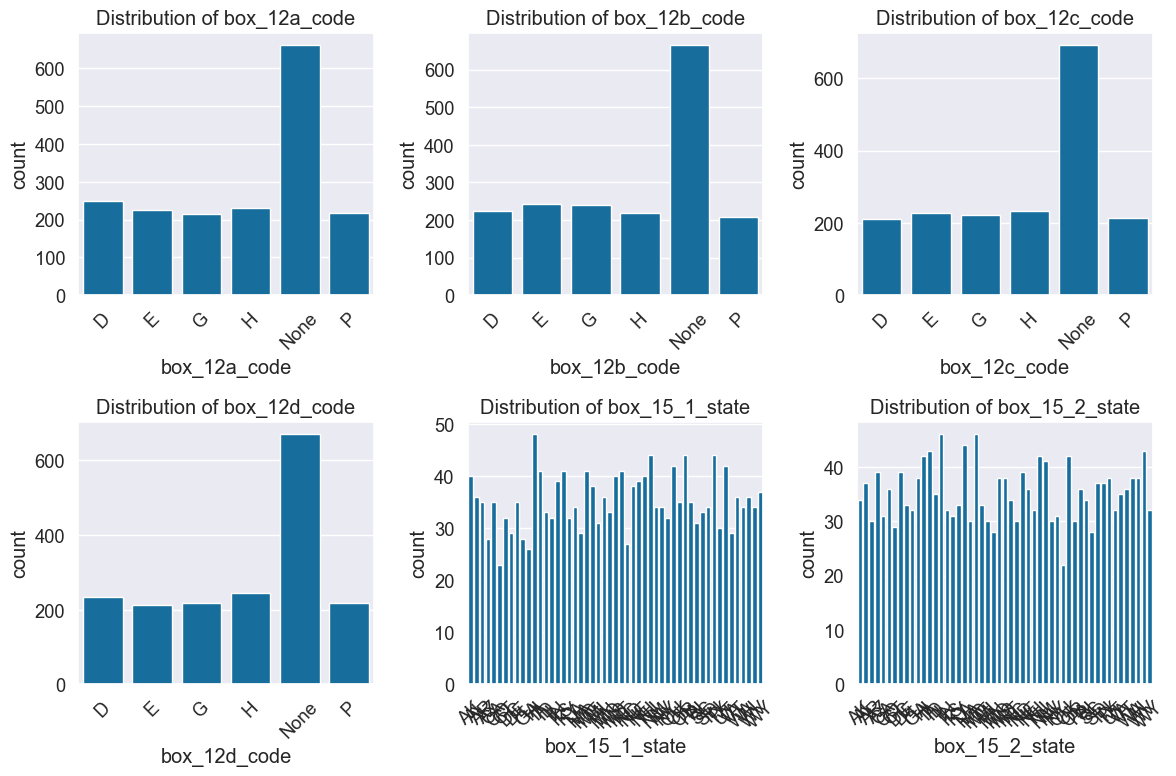

In [4]:
categorical_cols = original_data.select_dtypes(include=['category']).columns.tolist()

n = len(categorical_cols)
cols = math.ceil(math.sqrt(n))
rows = math.ceil(n / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(cols * 4, rows * 4))
axes = axes.flatten()

last = 0
for i, col in enumerate(categorical_cols):
    sns.countplot(data=original_data, x=col, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].tick_params(axis='x', rotation=45)
    last=i

for j in range(last + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

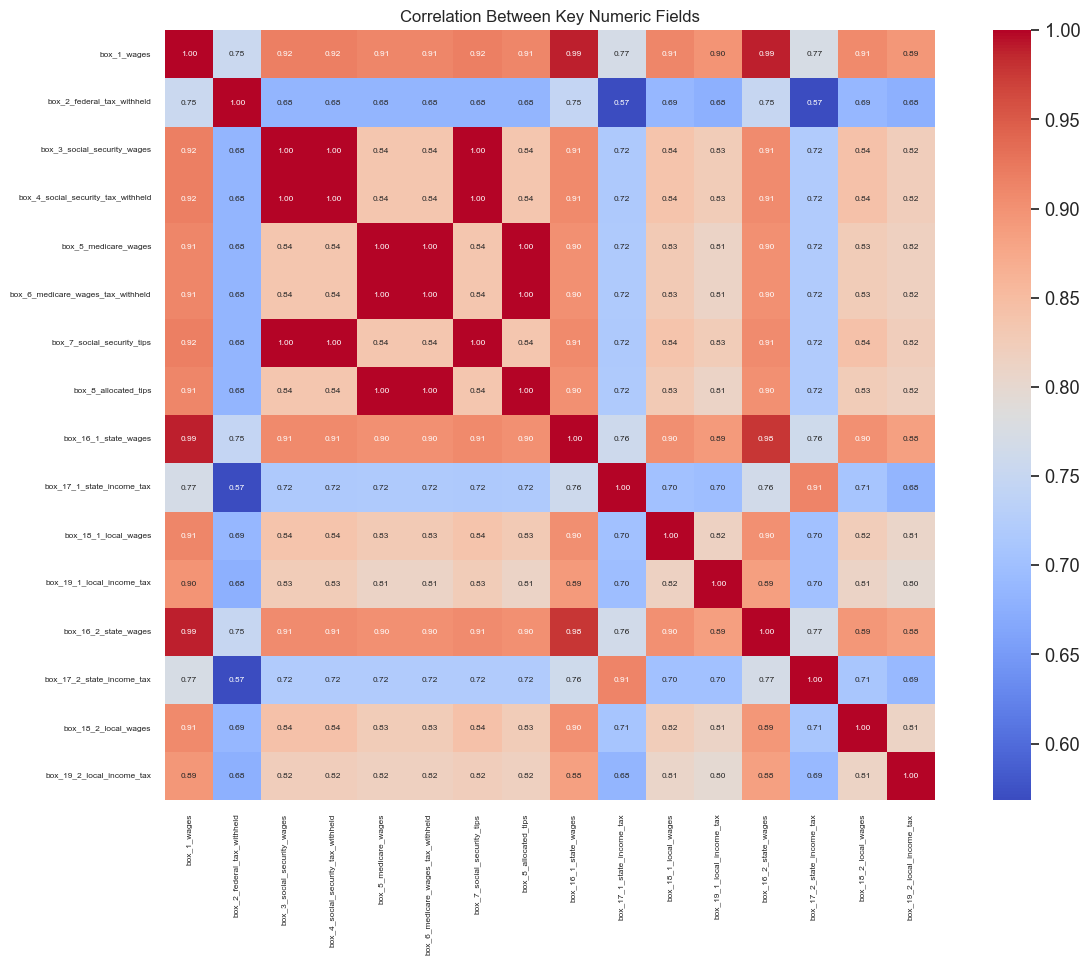

In [5]:
plt.figure(figsize=(15, 10))
numeric_fields = original_data.select_dtypes(include=['float64']).columns.tolist()

corr = original_data[numeric_fields].corr()
sns.heatmap(
    corr,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    square=True,
    cbar=True,
    annot_kws={"size": 6}
)
plt.xticks(rotation=90, fontsize=6)
plt.yticks(fontsize=6)
plt.title("Correlation Between Key Numeric Fields", fontsize=12)

all_features = original_data.columns.tolist()
correlated_fields = []


### Plot Relationships

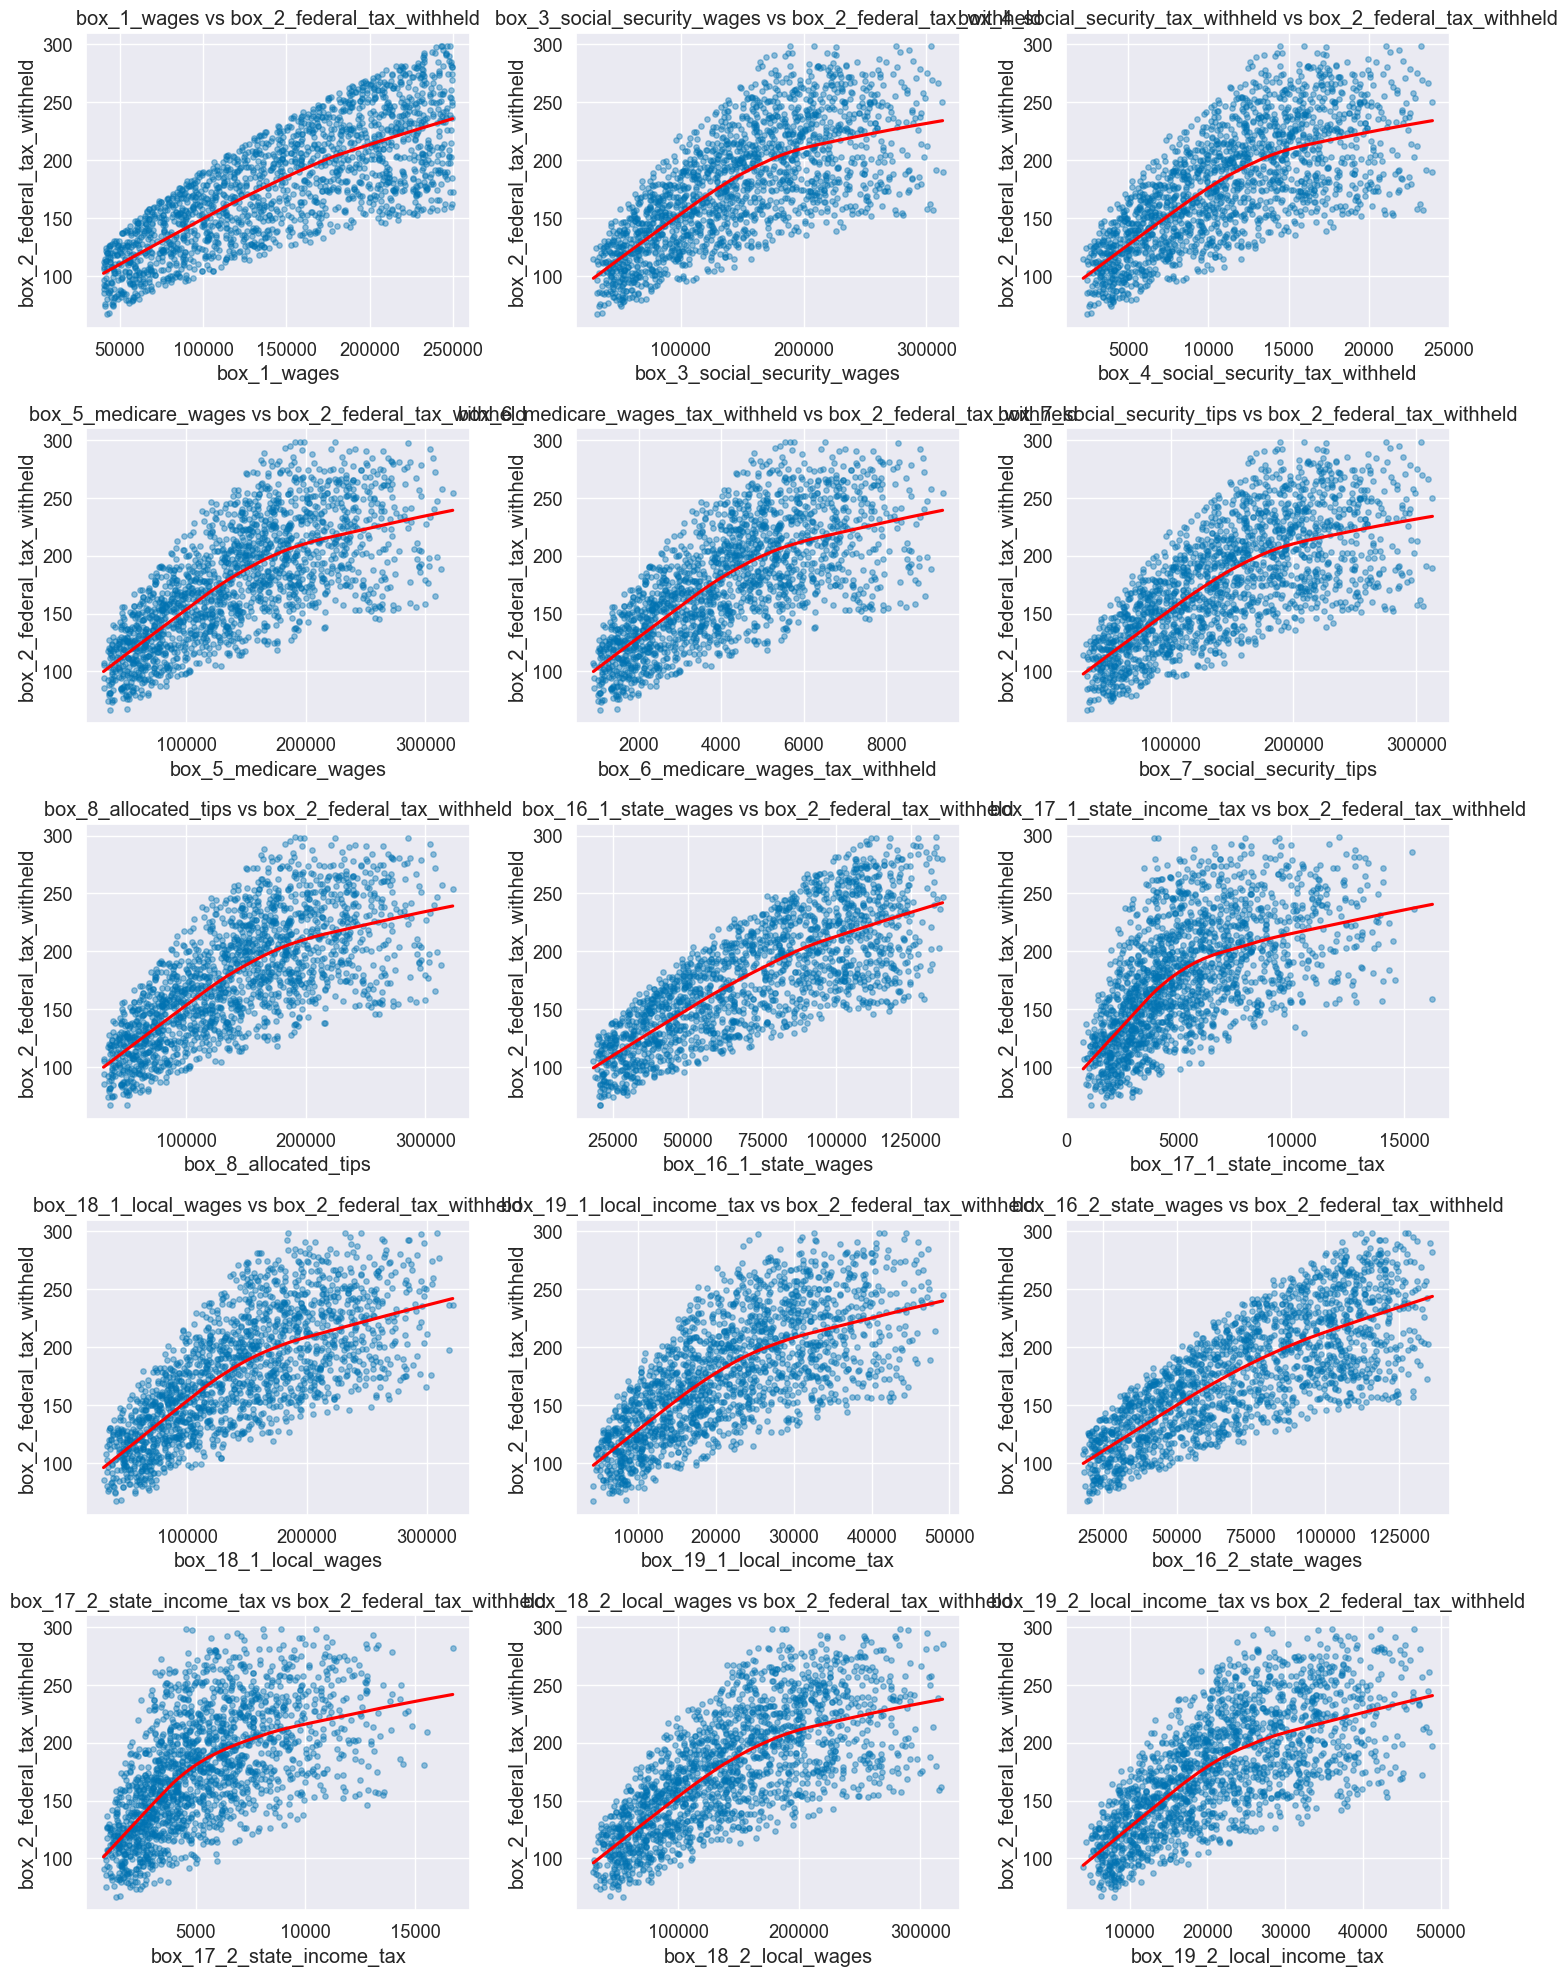

,column,dtype,n_unique,sample_values
0,box_1_wages,float64,1800,"[141194.15, 177856.29, 238111.55, 172580.36, 1..."
1,box_3_social_security_wages,float64,1800,"[169708.96, 197623.14, 309486.28, 181555.13, 1..."
2,box_4_social_security_tax_withheld,float64,1800,"[12982.74, 15118.17, 23675.7, 13888.97, 8679.29]"
3,box_5_medicare_wages,float64,1800,"[181642.61, 212875.46, 205695.97, 183423.78, 1..."
4,box_6_medicare_wages_tax_withheld,float64,1798,"[5267.64, 6173.39, 5965.18, 5319.29, 3343.82]"
5,box_7_social_security_tips,float64,1800,"[169708.96, 197623.14, 309486.28, 181555.13, 1..."
6,box_8_allocated_tips,float64,1800,"[181642.61, 212875.46, 205695.97, 183423.78, 1..."
7,box_16_1_state_wages,float64,1800,"[64971.88, 95662.66, 121453.85, 93302.6, 67691..."
8,box_17_1_state_income_tax,float64,1799,"[7258.57, 5075.61, 6858.46, 8216.98, 7191.07]"
9,box_18_1_local_wages,float64,1800,"[149192.1, 128884.24, 287711.19, 201665.8, 119..."


In [6]:
target = 'box_2_federal_tax_withheld'
to_exclude = ['box_15_1_state', 'box_15_2_state', 'box_13_retirement_plan', 'box_13_statutary_employee', 'box_13_third_part_sick_pay']
clean_mlr_df, plt_predictors = data_features(original_data, target, numeric_fields, correlated_fields + to_exclude)
plot_data = transform(df=clean_mlr_df, transformation='sqrt', target=target, scope=2)

cols = 3
rows = math.ceil(len(plt_predictors) / cols)
fig, axs = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))

axs = axs.flatten()
for i, feature in enumerate(plt_predictors):
    sns.regplot(
        x=plot_data[feature],
        y=plot_data[target],
        lowess=True,
        scatter_kws={'s': 15, 'alpha': 0.4},
        line_kws={'color': 'red'},
        ax=axs[i]
    )
    axs[i].set_title(f"{feature} vs {target}")

plt.tight_layout()
plt.show()

str_df(clean_mlr_df)

### Explain Federal withheld

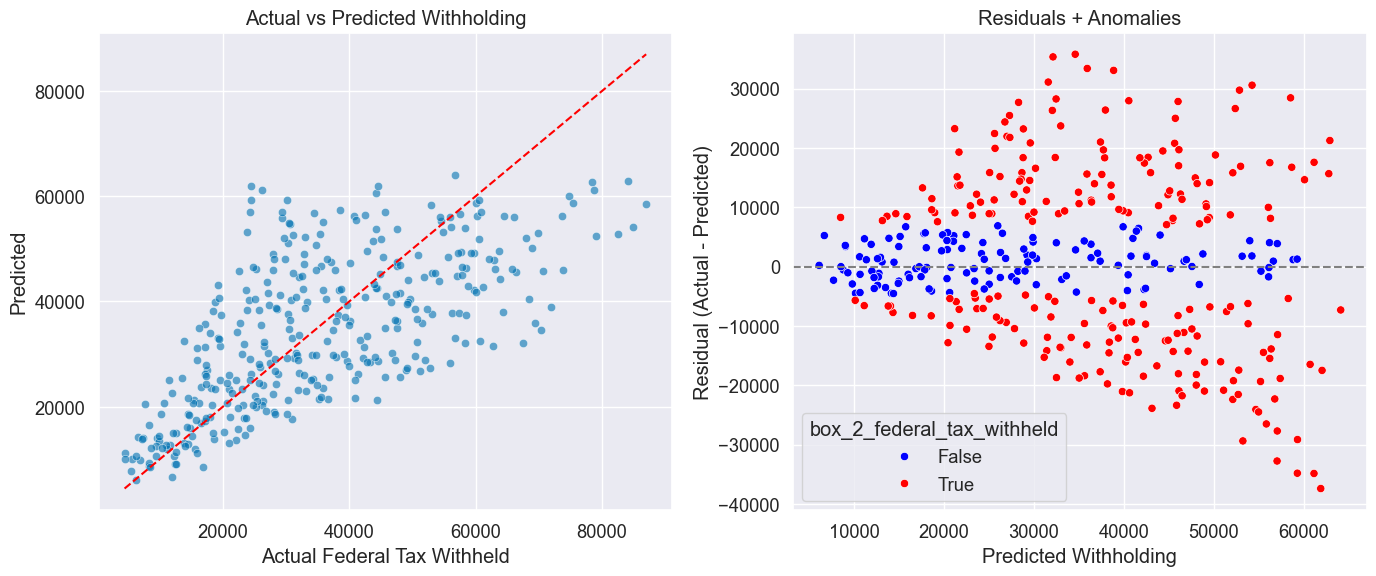

,Feature,Coefficient
2,box_4_social_security_tax_withheld,62269.996514
4,box_6_medicare_wages_tax_withheld,-17528.160629
1,box_3_social_security_wages,-8611.527033
5,box_7_social_security_tips,-8611.527006
3,box_5_medicare_wages,1492.463590
...,...,...
33,box_12c_G,-0.015953
11,box_18_1_local_wages,0.012915
12,box_19_1_local_income_tax,0.007685
28,box_12b_H,-0.006570


,R²,MAE,RMSE
0,0.442806,10650.451513,13516.019081


In [7]:
target = 'box_2_federal_tax_withheld'
to_encode = ['box_15_1_state', 'box_15_2_state', 'box_13_retirement_plan', 'box_13_statutary_employee', 'box_13_third_part_sick_pay']
encoded_df = encode_retirement_features(original_data, fill_zero=True)
encoded_df = pd.get_dummies(encoded_df, columns=to_encode, drop_first=True, dtype="int64")

features = encoded_df.columns.tolist()
clean_mlr_df, mlr_predictors = data_features(encoded_df, target, features, [])
clean_mlr_df = transform(df=clean_mlr_df, transformation='sqrt', target=target, scope=1)

X = clean_mlr_df[mlr_predictors]
y = clean_mlr_df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=SPLIT_RATIO, random_state=42)

mlr = LinearRegression()
mlr.fit(X_train, y_train)

predictions = mlr.predict(X_test)

# BackTransform
y_test = np.square(y_test)
predictions = np.square(predictions)
residuals = y_test - predictions

upper_threshold = residuals.quantile(1 - ANOMALY_RATE)
lower_threshold = residuals.quantile(ANOMALY_RATE)
anomalies = (residuals > upper_threshold) | (residuals < lower_threshold)

coefficients = pd.DataFrame({
    'Feature': mlr_predictors,
    'Coefficient': mlr.coef_
}).sort_values(by='Coefficient', key=abs, ascending=False)

metrics = pd.DataFrame([{
    "R²": r2_score(y_test, predictions),
    "MAE": mean_absolute_error(y_test, predictions),
    "RMSE": np.sqrt(mean_squared_error(y_test, predictions)),
}])


fig, axs = plt.subplots(1, 2, figsize=(14, 6))
sns.scatterplot(x=y_test, y=predictions, alpha=0.6, ax=axs[0])
axs[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
axs[0].set_xlabel("Actual Federal Tax Withheld")
axs[0].set_ylabel("Predicted")
axs[0].set_title("Actual vs Predicted Withholding")

sns.scatterplot(x=predictions, y=residuals, hue=anomalies, palette={True: 'red', False: 'blue'}, ax=axs[1])
axs[1].axhline(0, color='gray', linestyle='--')
axs[1].set_xlabel("Predicted Withholding")
axs[1].set_ylabel("Residual (Actual - Predicted)")
axs[1].set_title("Residuals + Anomalies")

plt.tight_layout()
plt.show()

## Now add anomalies to df
X_all = clean_mlr_df[mlr_predictors]
y_all = clean_mlr_df['box_2_federal_tax_withheld']
all_predictions = mlr.predict(X_all)
residuals_all = np.square(y_all) - np.square(all_predictions)
upper = residuals_all.quantile(1 - ANOMALY_RATE)
lower = residuals_all.quantile(ANOMALY_RATE)
encoded_df["anomaly"] = (residuals_all > upper) | (residuals_all < lower)

display(coefficients, metrics)

## Isolation Forest

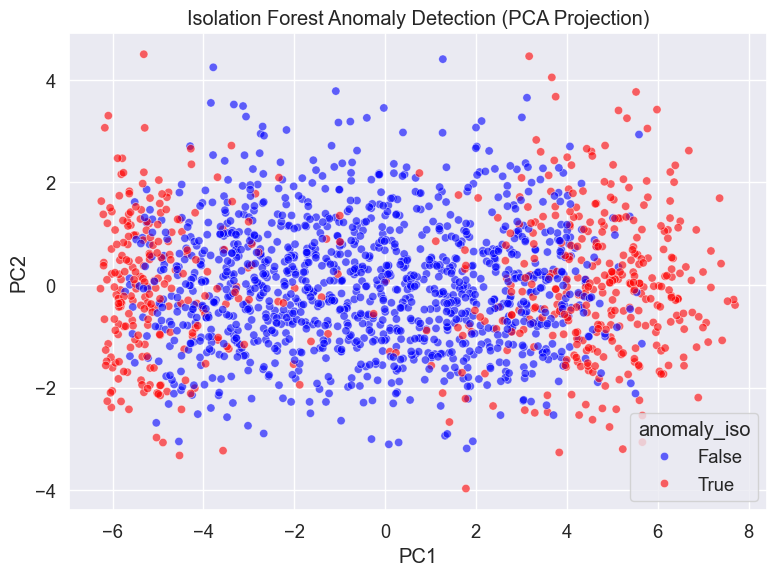

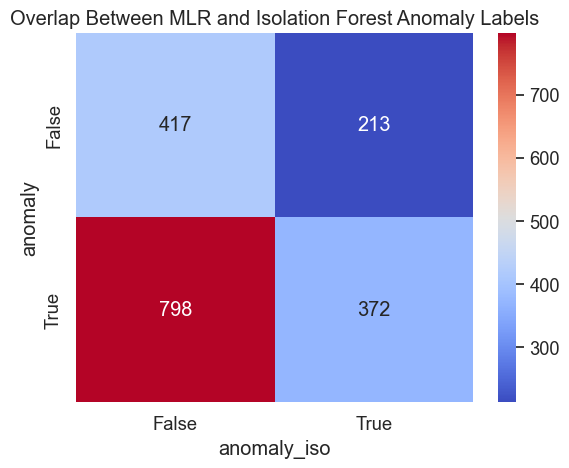

In [8]:
X = encoded_df.drop(columns=[target, "anomaly"])
iso = IsolationForest(
    n_estimators=10000,
    contamination=ANOMALY_RATE,
    random_state=42,
    max_features=0.3,
    bootstrap=True,
)

iso.fit(X)
predictions = iso.predict(X)
encoded_df["anomaly_iso"] = predictions == -1

pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))
encoded_df["PC1"] = X_pca[:, 0]
encoded_df["PC2"] = X_pca[:, 1]

plt.figure(figsize=(8, 6))
sns.scatterplot(
    x="PC1", y="PC2",
    hue="anomaly_iso",
    data=encoded_df,
    palette={True: "red", False: "blue"},
    alpha=0.6
)
plt.title("Isolation Forest Anomaly Detection (PCA Projection)")
plt.tight_layout()
plt.show()

sns.heatmap(
    pd.crosstab(encoded_df["anomaly"], encoded_df["anomaly_iso"]),
    annot=True, cmap="coolwarm", fmt="d"
)
plt.title("Overlap Between MLR and Isolation Forest Anomaly Labels")
plt.show()

## Consensus

Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - AUC: 0.5426 - accuracy: 0.5972 - loss: 0.7090 - val_AUC: 0.6959 - val_accuracy: 0.2806 - val_loss: 1.1949
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7121 - accuracy: 0.7802 - loss: 0.5354 - val_AUC: 0.7319 - val_accuracy: 0.4167 - val_loss: 1.2041
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.7610 - accuracy: 0.8004 - loss: 0.4858 - val_AUC: 0.7560 - val_accuracy: 0.5361 - val_loss: 1.0185
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.7963 - accuracy: 0.8196 - loss: 0.4506 - val_AUC: 0.7822 - val_accuracy: 0.6389 - val_loss: 0.7050
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.7962 - accuracy: 0.8255 - loss: 0.4383 - val_AUC: 0.8065 - val_accuracy: 0.6806 - val_loss: 0.6166
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.7903 - accuracy: 0.8280 - loss: 0.4254 - val_AUC: 0.8170 - val_accuracy: 0.7222 - val_loss: 0.5179
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - 

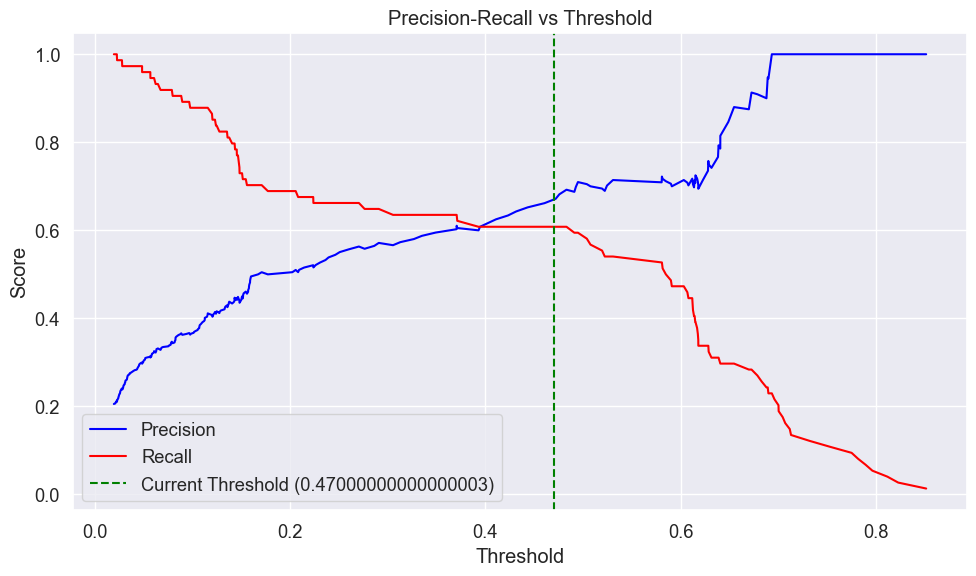

In [9]:
target = "anomaly_consensus"
encoded_df[target] = encoded_df["anomaly"] & encoded_df["anomaly_iso"]


X = encoded_df.drop(columns=["box_2_federal_tax_withheld", "anomaly", "anomaly_iso"])
y = encoded_df[target]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=SPLIT_RATIO, stratify=y, random_state=42
)

model = build_anomaly_model(input_dim=X.shape[1])

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)],
    verbose=1
)

local_th = PROB_THRESHOLD + 0.02
y_proba_cons = model.predict(X_test).flatten()
nn_cons_pred = (y_proba_cons >= local_th).astype(int)

print(classification_report(y_test, nn_cons_pred))
print("AUC (Consensus Model):", roc_auc_score(y_test, y_proba_cons))

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_cons)

plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label="Precision", color="blue")
plt.plot(thresholds, recall[:-1], label="Recall", color="red")
plt.axvline(x=local_th, color='green', linestyle='--', label=f"Current Threshold ({local_th})")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision-Recall vs Threshold")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


encoded_df.loc[X_test.index, "nn_anomaly_consensus_pred"] = nn_cons_pred
encoded_df.loc[X_test.index, "nn_anomaly_consensus_proba"] = y_proba_cons

### Kmeans

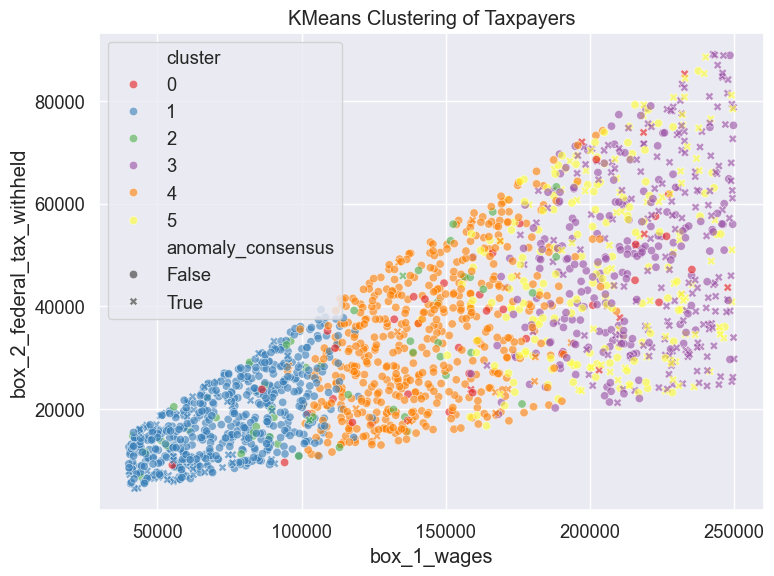

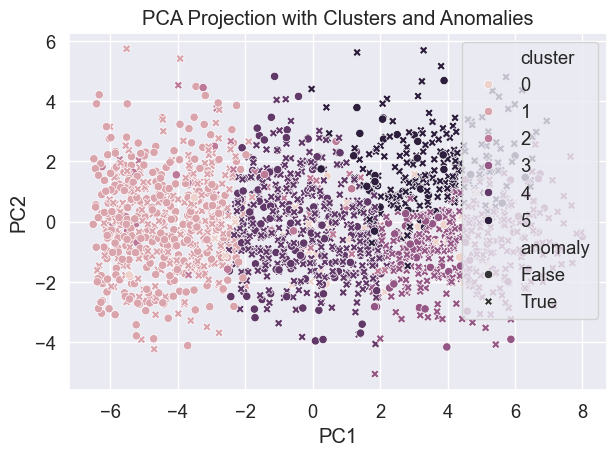

In [10]:
target = 'box_2_federal_tax_withheld'

features = encoded_df.select_dtypes(exclude=['category']).columns.tolist()
clean_km_df, predictors = data_features(encoded_df, target, features, [])

X_km = encoded_df.drop(columns=[
    target,
    "anomaly",
    "anomaly_iso",
    "anomaly_consensus",
    "nn_anomaly_consensus_pred",
    "nn_anomaly_consensus_proba"
])

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_km)

# Run KMeans clustering
kmeans = KMeans(n_clusters=6, random_state=42, max_iter=500)
clusters = kmeans.fit_predict(X_scaled)

# Add clusters
clean_km_df['cluster'] = clusters
clean_km_df['anomaly_consensus'] = encoded_df.loc[clean_km_df.index, 'anomaly_consensus']

plot_cols = ['box_1_wages', 'box_2_federal_tax_withheld']
plt.figure(figsize=(8, 6))
sns.scatterplot(
    x=clean_km_df[plot_cols[0]],
    y=clean_km_df[plot_cols[1]],
    hue=clean_km_df['cluster'],
    style=clean_km_df['anomaly_consensus'],
    palette='Set1',
    alpha=0.6
)
plt.title("KMeans Clustering of Taxpayers")
plt.xlabel(plot_cols[0])
plt.ylabel(plot_cols[1])
plt.tight_layout()
plt.show()


pca = PCA(n_components=3).fit(X_scaled)
X_pca = pca.transform(X_scaled)

# Store 3D PCA projection
clean_km_df["PC1"] = X_pca[:, 0]
clean_km_df["PC2"] = X_pca[:, 1]
clean_km_df["PC3"] = X_pca[:, 2]

encoded_df['cluster'] = clusters
sns.scatterplot(x="PC1", y="PC2", hue="cluster", style="anomaly", data=clean_km_df)
plt.title("PCA Projection with Clusters and Anomalies")
plt.tight_layout()
plt.show()

joblib.dump(scaler, "inference/kmeans_scaler.pkl")
joblib.dump(pca, "inference/kmeans_pca.pkl")
joblib.dump(kmeans, "inference/kmeans_model.pkl")
joblib.dump(X_km.columns.tolist(), "inference/kmeans_feature_cols.pkl")


clean_km_df[["PC1", "PC2", "PC3", "cluster", "anomaly"]].to_json("output/cluster_points.json", orient="records")

## Random Forest

In [11]:
X = encoded_df.drop(columns=[
    target,
    "anomaly",
    "anomaly_iso",
    "anomaly_consensus",
    "nn_anomaly_consensus_pred",
    "nn_anomaly_consensus_proba"
])
y = encoded_df["anomaly_consensus"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=SPLIT_RATIO, stratify=y, random_state=42
)

param_dist = {
    'n_estimators': list(range(100, 901, 50)),
    'max_depth': [5, 10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', 0.5, 0.75, 1.0]
}
# Randomized search
rf_best = RandomizedSearchCV(
    RandomForestClassifier(class_weight='balanced_subsample'),
    param_distributions=param_dist,
    n_iter=50,
    cv=10,
    scoring='roc_auc',
    verbose=1,
    random_state=42,
    n_jobs=-1,
)

# Warning takes sometime
rf_best.fit(X_train, y_train)
rf = rf_best.best_estimator_
rf.fit(X_train, y_train)

pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]
rf_pred = (y_proba >= PROB_THRESHOLD).astype(int)

print(classification_report(y_test, rf_pred))
print("AUC:", roc_auc_score(y_test, y_proba))

Fitting 10 folds for each of 50 candidates, totalling 500 fits
              precision    recall  f1-score   support

       False       0.91      0.91      0.91       286
        True       0.64      0.65      0.64        74

    accuracy                           0.85       360
   macro avg       0.77      0.78      0.78       360
weighted avg       0.85      0.85      0.85       360

AUC: 0.876960876960877


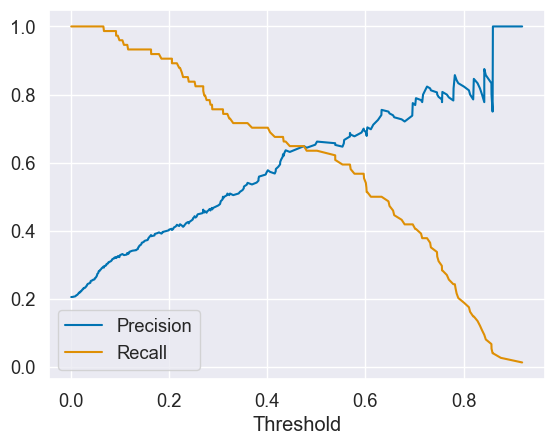

In [12]:
imp = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

metrics = pd.DataFrame([{
    'precision': precision,
    'recall': recall,
    'thresholds': thresholds,
}])

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel("Threshold")
plt.legend()
plt.show()

In [13]:
clean_km_df.groupby("cluster")[['anomaly_consensus']].describe()


anomaly_consensus                   
                    count unique    top freq
cluster                                     
0                      45      2  False   37
1                     557      2  False  487
2                      54      2  False   51
3                     394      2  False  202
4                     509      2  False  492
5                     241      2  False  159

# Shap

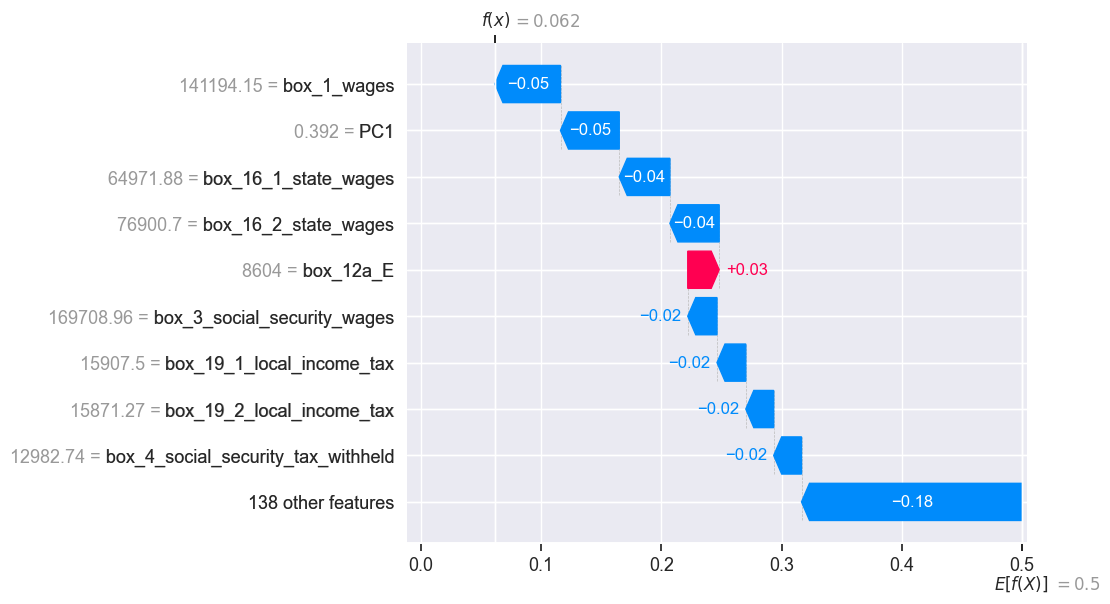

In [14]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X)

sample_index = 0
row = X.iloc[sample_index]
row_values = row.values
row_features = row.index

# Use correct indexing for axis-aligned SHAP output
shap_vals_row = shap_values[sample_index, :, 1]
base_value = explainer.expected_value[1]

# Show interactive force plot
shap.plots.waterfall(shap.Explanation(
    values=shap_vals_row,
    base_values=base_value,
    data=row_values,
    feature_names=row_features
))

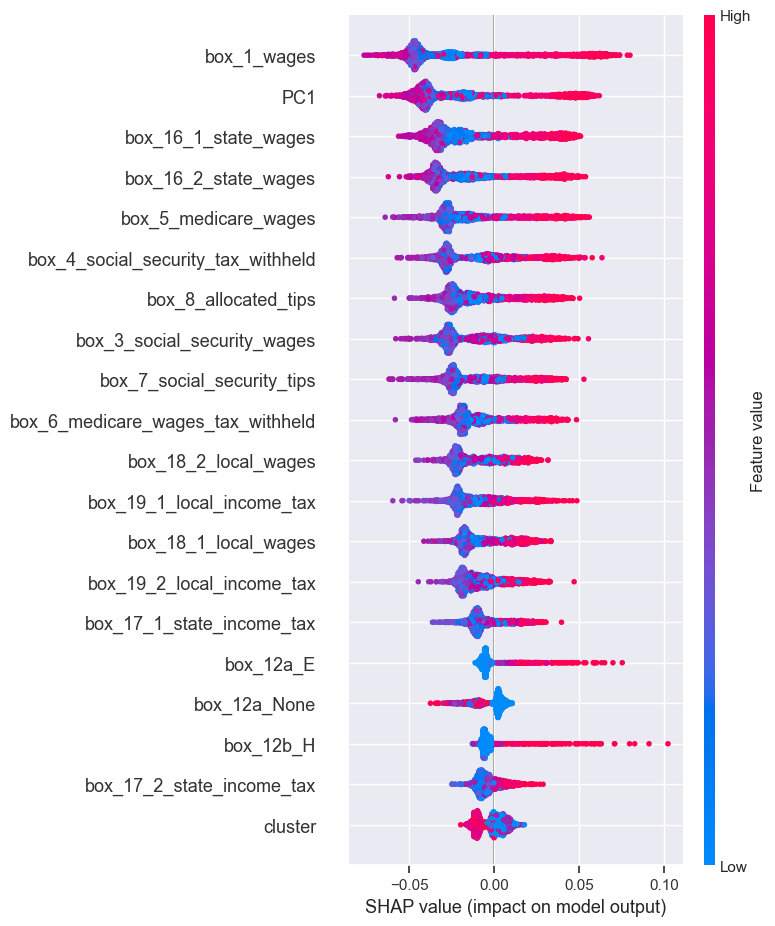

In [15]:
shap.summary_plot(shap_values[:, :, 1], X)

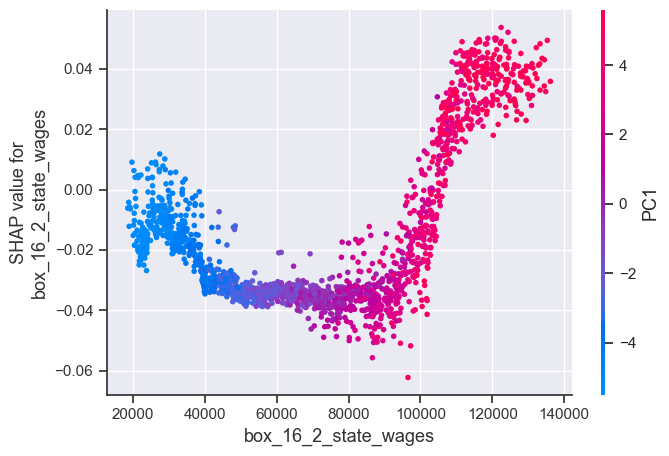

In [16]:
shap.dependence_plot(
    ind="box_16_2_state_wages",
    shap_values=shap_values[:, :, 1],  # class 1 = anomaly
    features=X,
    interaction_index="auto"
)

### Tensor Flow

In [17]:
original_data["cluster"] = encoded_df["cluster"]
original_data["anomaly_consensus"] = encoded_df["anomaly_consensus"]

# === STEP 1: PREP FEATURES ===
categorical_cols = original_data.select_dtypes(include=["category"]).columns.tolist()
numeric_cols = original_data.select_dtypes(include=["float64", "int64"]).drop(columns=["box_2_federal_tax_withheld"], errors='ignore').columns.tolist()
target = "anomaly_consensus"

# Encode categoricals
for col in categorical_cols:
    original_data[col] = original_data[col].astype("category")
    original_data[f"{col}_id"] = original_data[col].cat.codes

# Create input arrays
X_numeric = original_data[numeric_cols].values
X_categoricals = {
    f"{col}_input": original_data[f"{col}_id"].values for col in categorical_cols
}
y = original_data[target].astype(int).values

# === STEP 2: SPLIT ===
splitter = StratifiedShuffleSplit(n_splits=1, test_size=SPLIT_RATIO, random_state=42)
(train_idx, test_idx), = splitter.split(X_numeric, y)

X_num_train, X_num_test = X_numeric[train_idx], X_numeric[test_idx]
y_train, y_test = y[train_idx], y[test_idx]
X_cat_train = {k: v[train_idx] for k, v in X_categoricals.items()}
X_cat_test = {k: v[test_idx] for k, v in X_categoricals.items()}

# === STEP 4: TRAIN ===
cat_cardinalities = {f"{col}_input": original_data[col].nunique() for col in categorical_cols}
model = build_embedding_model(X_numeric.shape[1], cat_cardinalities)

train_inputs = {"numeric_input": X_num_train, **X_cat_train}
test_inputs = {"numeric_input": X_num_test, **X_cat_test}


model.fit(
    train_inputs,
    y_train,
    validation_data=(test_inputs, y_test),
    epochs=30,
    batch_size=32,
    callbacks=[keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

# === STEP 5: EVALUATE ===
y_proba = model.predict(test_inputs).flatten()
thresh = PROB_THRESHOLD
pred = (y_proba >= thresh).astype(int)

print(classification_report(y_test, pred))
print("AUC:", roc_auc_score(y_test, y_proba))


Epoch 1/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - AUC: 0.6611 - accuracy: 0.6682 - loss: 0.6990 - val_AUC: 0.7105 - val_accuracy: 0.2639 - val_loss: 2.4794
Epoch 2/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7303 - accuracy: 0.7918 - loss: 0.5533 - val_AUC: 0.7424 - val_accuracy: 0.4694 - val_loss: 1.3589
Epoch 3/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.7756 - accuracy: 0.8145 - loss: 0.4698 - val_AUC: 0.7645 - val_accuracy: 0.5889 - val_loss: 0.8316
Epoch 4/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - AUC: 0.8022 - accuracy: 0.8308 - loss: 0.4318 - val_AUC: 0.8032 - val_accuracy: 0.6556 - val_loss: 0.5981
Epoch 5/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.7683 - accuracy: 0.8029 - loss: 0.4298 - val_AUC: 0.8185 - val_accuracy: 0.7139 - val_loss: 0.5628
Epoch 6/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.8081 - accuracy: 0.8348 - loss: 0.4185 - val_AUC: 0.8239 - val_accuracy: 0.7278 - val_loss: 0.5083
Epoch 7/30
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - 

## Save final

In [21]:
# Embedding
embedding_model = models.Model(inputs=model.input, outputs=model.get_layer("dense_embedding").output)

X_all_num = X_numeric
X_all_cat = {k: v for k, v in X_categoricals.items()}
full_input_dict = {"numeric_input": X_all_num, **X_all_cat}

embeddings = embedding_model.predict(full_input_dict)
np.savetxt("output/tax_embeddings.tsv", embeddings.reshape(len(embeddings), -1), delimiter="\t")

metadata = original_data.copy()
metadata = metadata[categorical_cols + numeric_cols + ["box_2_federal_tax_withheld", "anomaly_consensus", "cluster", "box_15_1_state"]]
metadata.to_csv("output/tax_metadata.tsv", sep="\t", index=False)

model.save("inference/final_keras_anomaly_model.keras")
embedding_model.save("inference/keras_embedding_model.keras")

joblib.dump(categorical_cols, "inference/categorical_cols.pkl")
joblib.dump(numeric_cols, "inference/numeric_cols.pkl")
cat_vocab = {f"{col}_input": original_data[col].astype("category").nunique() for col in categorical_cols}
joblib.dump(cat_vocab, "inference/cat_vocab.pkl")

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


['inference/cat_vocab.pkl']